In [1]:
%load_ext autoreload
%autoreload 2

In [13]:
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt

from neuralbridge.stochastic_processes.examples import DoubleWellPotentialDiffusionProcess, DoubleWellPotentialDiffusionAuxProcess, DoubleWellPotentialDiffusionAuxProcessBetter
from neuralbridge.solvers.sde import WienerProcess, Euler
from neuralbridge.stochastic_processes.conds import GuidedBridgeProcess
from neuralbridge.networks.mlps import MLPSmall
from neuralbridge.models import neurb, pCN, scorematching
from neuralbridge.utils.plotting import plot_sample_path, plot_mcmc_sample_path

### One-dimensional case

#### Guiding with OU process

In [65]:
dim = 1
T = 10.0
dt = 1 / 100
seed = 42

u = jnp.array([0.0])
v = jnp.array([1.0])
params = {
    "sigma": 0.05,
    "v": 1.0,
}
L0 = jnp.eye(dim)

In [84]:
W = WienerProcess(T, dt, shape=(dim, ))
X = DoubleWellPotentialDiffusionProcess(params, T, dim)
# X_aux = DoubleWellPotentialDiffusionAuxProcess(params, T, dim)
X_aux = DoubleWellPotentialDiffusionAuxProcessBetter(params, T, dim)

In [85]:
X_solver = Euler(X, W)
X_aux_solver = Euler(X_aux, W)

rng_key = jax.random.PRNGKey(42)
batch_size = 32

In [86]:
X_path = X_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
X_aux_path = X_aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)

<Axes: title={'center': 'Double Well Auxiliary Process (Taylor expansion)'}>

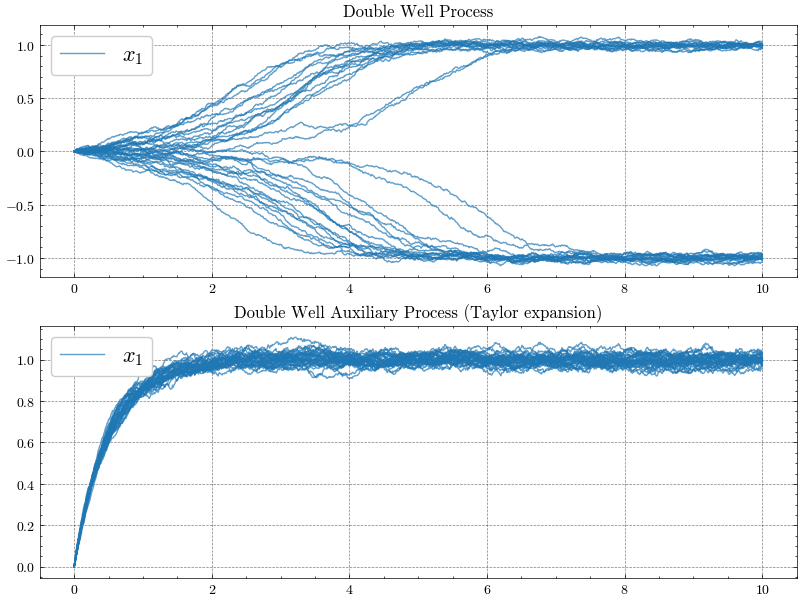

In [87]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), layout="constrained")
plot_sample_path(X_path, ax=ax[0], label=["$x_1$"], title="Double Well Process")
plot_sample_path(X_aux_path, ax=ax[1], label=["$x_1$"], title="Double Well Auxiliary Process (Taylor expansion)")

Do a brutal force sampling to find the true conditional process

In [70]:
X_path_many = X_solver.solve(x0=u, rng_key=rng_key, batch_size=100000)

In [71]:
# Create masks for each coordinate's end point conditions
x1_mask = (X_path_many.xs[:, -1, 0] >= 0.9999) & (X_path_many.xs[:, -1, 0] <= 1.0001)
# x2_mask = (X_path_many.xs[:, -1, 1] >= -1.01) & (X_path_many.xs[:, -1, 1] <= -0.99)
# x3_mask = (X_path_many.xs[:, -1, 2] >= 0.99) & (X_path_many.xs[:, -1, 2] <= 1.01)

# Combine all masks
final_mask = x1_mask

# Filter trajectories
X_path_filtered = X_path_many[final_mask]

print(f"Number of filtered trajectories: {X_path_filtered.n_samples} out of {X_path_many.n_samples}")

<Axes: title={'center': 'Filtered Trajectories'}>

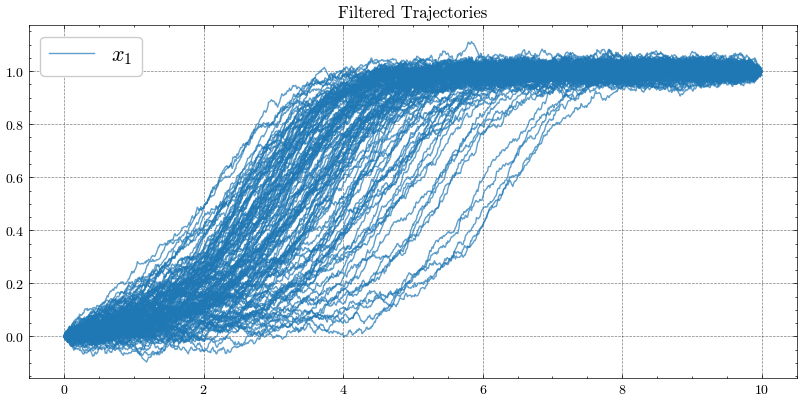

In [72]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout="constrained")
plot_sample_path(X_path_filtered, ax=ax, label=["$x_1$"], title="Filtered Trajectories")

In [88]:
X_gui = GuidedBridgeProcess(
    X,
    X_aux,
    u,
    v,
    L0,
    Sigma0=jnp.eye(dim) * 1e-8,
    ts=jnp.arange(0.0, T + dt, dt),
    ode_solver_kernel="dopri5"
)

<Axes: title={'center': 'Guided Bridge Process (With Taylor Expansion Aux)'}>

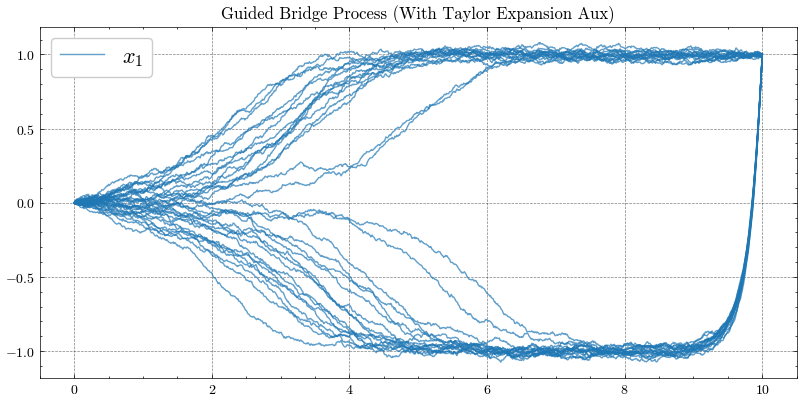

In [89]:
X_gui_solver = Euler(X_gui, W)
X_gui_path = X_gui_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout="constrained")
plot_sample_path(X_gui_path, ax=ax, label=["$x_1$"], title="Guided Bridge Process (With Taylor Expansion Aux)")


In [90]:
pCN_config = {
    "seed": seed,
    "rho": 0.9,
    "batch_size": 100,
    "n_iters": 10000
}
pCN_model = pCN.PreconditionedCrankNicolson(X_gui=X_gui, config=pCN_config)
pCN_model.initialize_solver(W)
logs, pCN_result = pCN_model.run(log_every=100)

Running pCN with log every 100:   0%|          | 0/10000 [00:00<?, ?it/s]

<Axes: title={'center': 'pCN Bridge (Taylor Expansion Aux)'}>

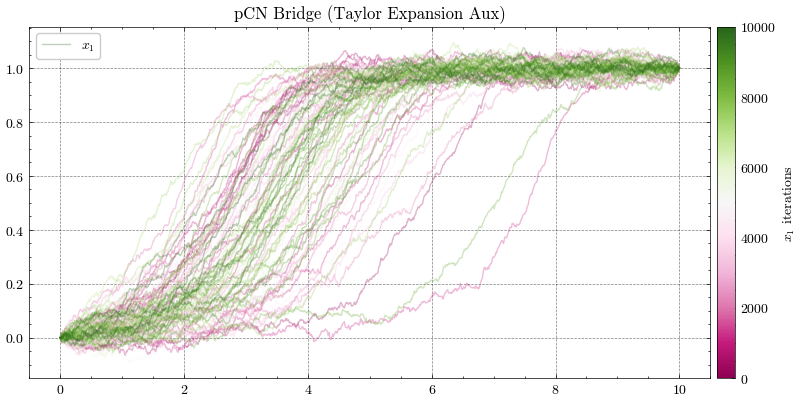

In [91]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout="constrained")
plot_mcmc_sample_path(logs, sample_index=0, plot_dims=(0, ), ax=ax, label=["$x_1$"], cmaps=("PiYG", ), title="pCN Bridge (Taylor Expansion Aux)", alpha=0.3, n_iters=10000)

# ax[1].plot(jnp.mean(pCN_OU_result.log_lls, axis=-1))
# ax[1].set_xlabel("Iteration")
# ax[1].set_ylabel("Log-likelihood")
# ax[1].set_title("MCMC Log-likelihood")

<Axes: title={'center': 'pCN Bridge (OU Aux)'}>

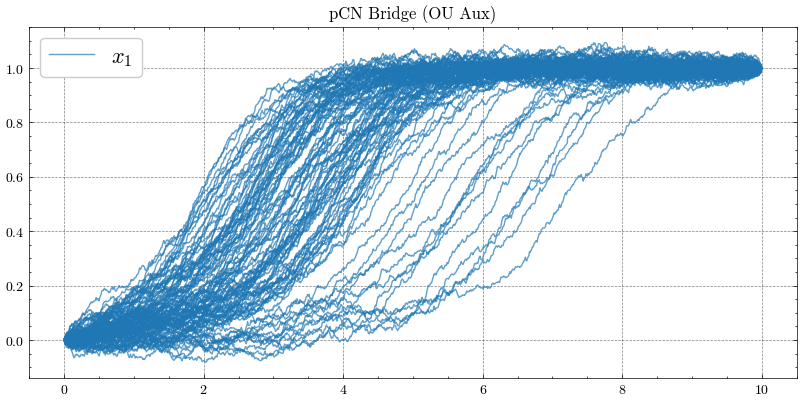

In [92]:
fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout="constrained")
plot_sample_path(pCN_result.path, ax=ax, label=["$x_1$"], title="pCN Bridge (OU Aux)")

In [93]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(20, 20, 20),
    activation="tanh",
)

In [94]:
train_config = {
    "save_name": "double_well_model_10T_1d_ou_aux",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 16,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 1000
}

In [95]:
neural_bridge = neurb.NeuralBridge(X_gui, neural_net, train_config)

In [96]:
W = WienerProcess(T, dt, shape=(dim, ))
neural_bridge.initialize_solver(W)
losses = neural_bridge.train(mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 2:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 3:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 4:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 5:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 6:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 7:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 8:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 9:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 10:   0%|          | 0/1000 [00:00<?, ?iter/s]

<Axes: title={'center': 'Neural Bridge (Taylor Expansion Aux)'}>

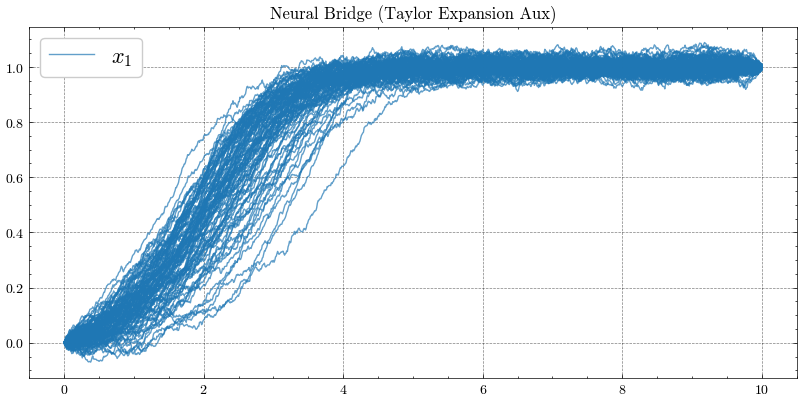

In [97]:
X_diamond_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=100)
fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout="constrained")
plot_sample_path(X_diamond_path, ax=ax, label=["$x_1$"], title="Neural Bridge (Taylor Expansion Aux)")

### Multi-dimensional case

In [30]:
dim = 5
T = 10.0
dt = 1 / 50

params = {
    "sigma": 0.01
}

seed = 42
u = jnp.array([0.0, 0.0, 0.0, 0.0, 0.0])
# Observe only the first three coordinates
v = jnp.array([1.0, -1.0, 1.0, jnp.nan, jnp.nan])
L0 = jnp.array([[1.0, 0.0, 0.0, 0.0, 0.0],
                [0.0, 1.0, 0.0, 0.0, 0.0],
                [0.0, 0.0, 1.0, 0.0, 0.0]])

In [10]:
W = WienerProcess(T, dt, shape=(dim, ))
X = DoubleWellPotentialDiffusionProcess(params, T, dim)
X_aux = DoubleWellPotentialDiffusionAuxProcess(params, T, dim)

In [11]:
X_solver = Euler(X, W)
X_aux_solver = Euler(X_aux, W)

rng_key = jax.random.PRNGKey(seed)
batch_size = 32

In [12]:
X_path = X_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
X_aux_path = X_aux_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)

<Axes: title={'center': 'Double Well Auxiliary Process'}>

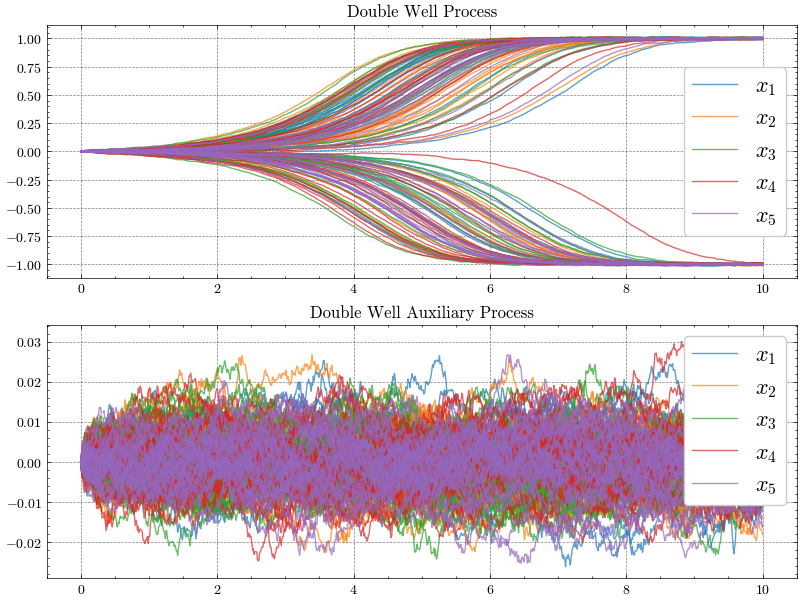

In [13]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), layout="constrained")
plot_sample_path(X_path, ax=ax[0], label=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"], title="Double Well Process")
plot_sample_path(X_aux_path, ax=ax[1], label=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"], title="Double Well Auxiliary Process")

In [14]:
X_path_many = X_solver.solve(x0=u, rng_key=rng_key, batch_size=100000)
# %timeit -n10 X_path_many = X_solver.solve(x0=u, rng_key=rng_key, batch_size=10000)

In [15]:
# Create masks for each coordinate's end point conditions
x1_mask = (X_path_many.xs[:, -1, 0] >= 0.99) & (X_path_many.xs[:, -1, 0] <= 1.01)
x2_mask = (X_path_many.xs[:, -1, 1] >= -1.01) & (X_path_many.xs[:, -1, 1] <= -0.99)
x3_mask = (X_path_many.xs[:, -1, 2] >= 0.99) & (X_path_many.xs[:, -1, 2] <= 1.01)

# Combine all masks
final_mask = x1_mask & x2_mask & x3_mask

# Filter trajectories
X_path_filtered = X_path_many[final_mask]

print(f"Number of filtered trajectories: {X_path_filtered.n_samples} out of {X_path_many.n_samples}")


<Axes: title={'center': 'Selected Trajectories (last 2 dims)'}>

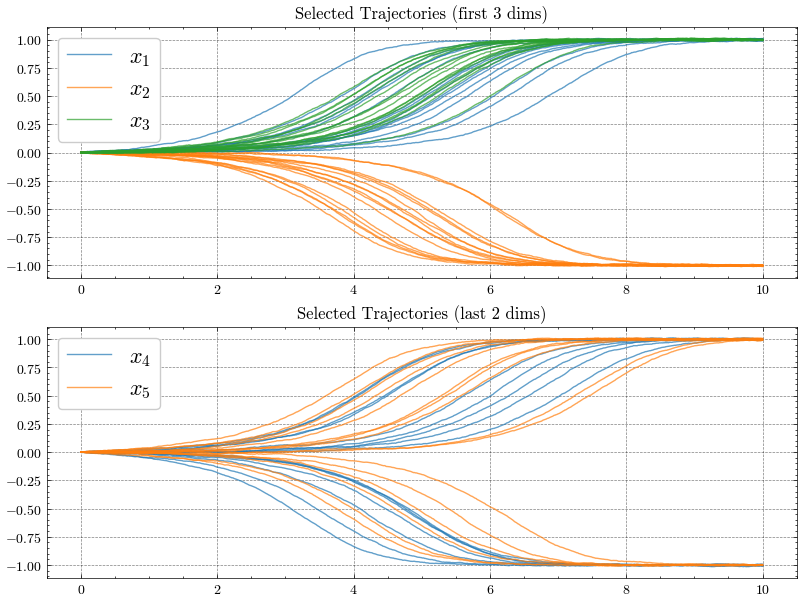

In [41]:
fig, ax = plt.subplots(2, 1, figsize=(8, 6), layout="constrained")
plot_sample_path(X_path_filtered[:16], plot_dims=(0, 1, 2), ax=ax[0], label=["$x_1$", "$x_2$", "$x_3$"], title="Selected Trajectories (first 3 dims)")
plot_sample_path(X_path_filtered[:16], plot_dims=(3, 4), ax=ax[1], label=["$x_4$", "$x_5$"], title="Selected Trajectories (last 2 dims)")

In [38]:
X_gui = GuidedBridgeProcess(
    X,
    X_aux,
    u,
    v,
    L0,
    Sigma0=jnp.eye(3) * 1e-10,
    ts=jnp.arange(0.0, T + dt, dt),
    ode_solver_kernel="dopri5"
)

<Axes: title={'center': 'Guided Bridge Process'}>

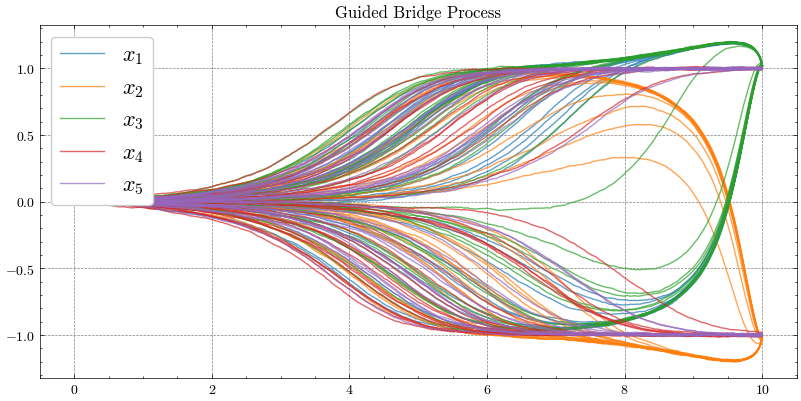

In [40]:
X_gui_solver = Euler(X_gui, W)
X_gui_path = X_gui_solver.solve(x0=u, rng_key=rng_key, batch_size=batch_size)
fig, ax = plt.subplots(1, 1, figsize=(8, 4), layout="constrained")
plot_sample_path(X_gui_path, ax=ax, label=["$x_1$", "$x_2$", "$x_3$", "$x_4$", "$x_5$"], title="Guided Bridge Process")

In [50]:
pCN_config = {
    "seed": seed,
    "rho": 0.9,
    "batch_size": 100,
    "n_iters": 20000
}
pCN_model = pCN.PreconditionedCrankNicolson(X_gui=X_gui, config=pCN_config)
pCN_model.initialize_solver(W)
logs, pCN_result = pCN_model.run(log_every=100)

Running pCN with log every 100:   0%|          | 0/20000 [00:00<?, ?it/s]

Text(0.5, 1.0, 'MCMC Log-likelihood')

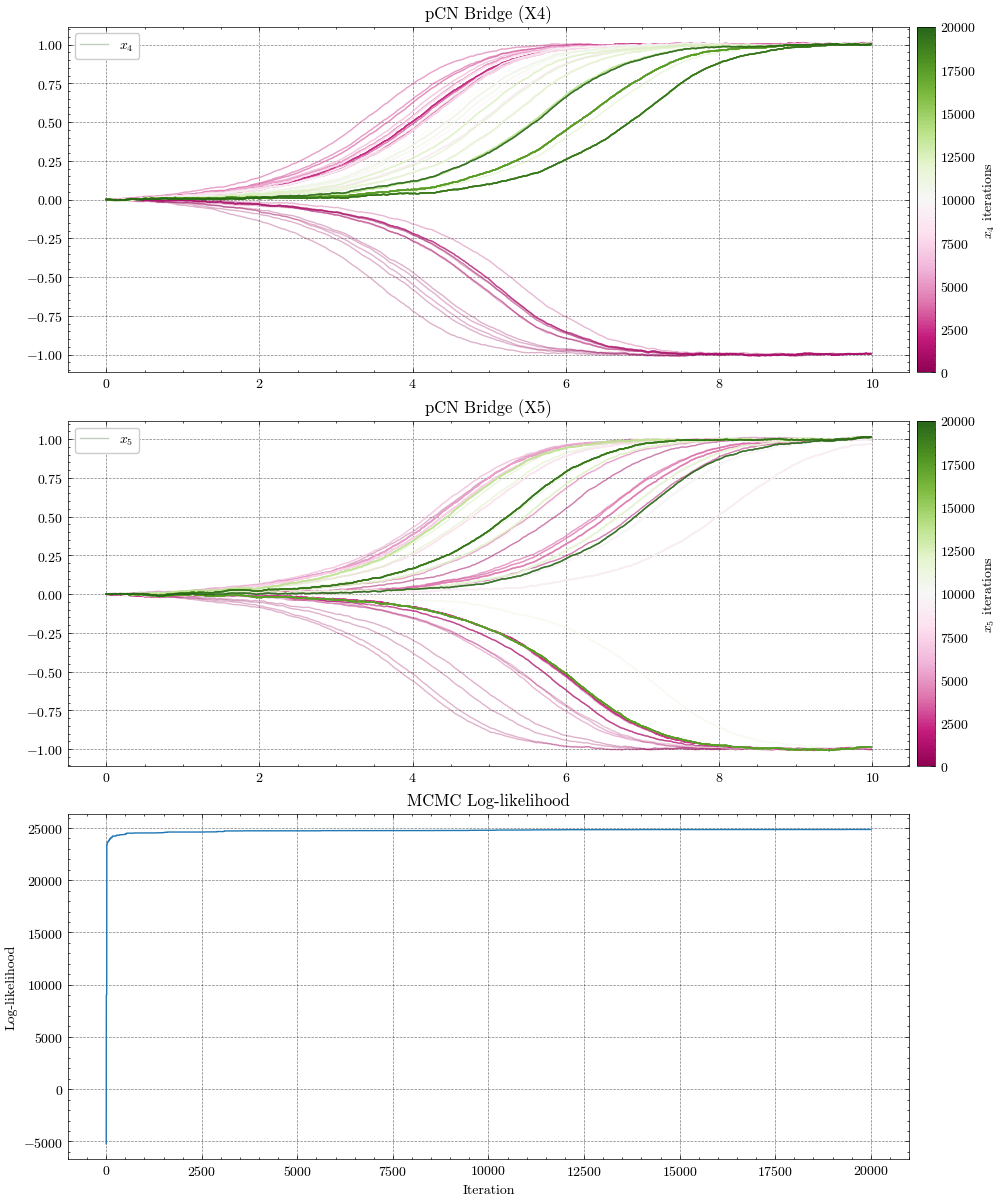

In [43]:
fig, ax = plt.subplots(3, 1, figsize=(10, 12), layout="constrained")
plot_mcmc_sample_path(logs, sample_index=0, plot_dims=(3, ), ax=ax[0], label=["$x_4$"], cmaps=("PiYG", ), title="pCN Bridge (X4)", alpha=0.3, n_iters=20000)
plot_mcmc_sample_path(logs, sample_index=0, plot_dims=(4, ), ax=ax[1], label=["$x_5$"], cmaps=("PiYG", ), title="pCN Bridge (X5)", alpha=0.3, n_iters=20000)

ax[2].plot(jnp.mean(pCN_result.log_lls, axis=-1))
ax[2].set_xlabel("Iteration")
ax[2].set_ylabel("Log-likelihood")
ax[2].set_title("MCMC Log-likelihood")

Text(0.5, 0.98, 'pCN Bridge')

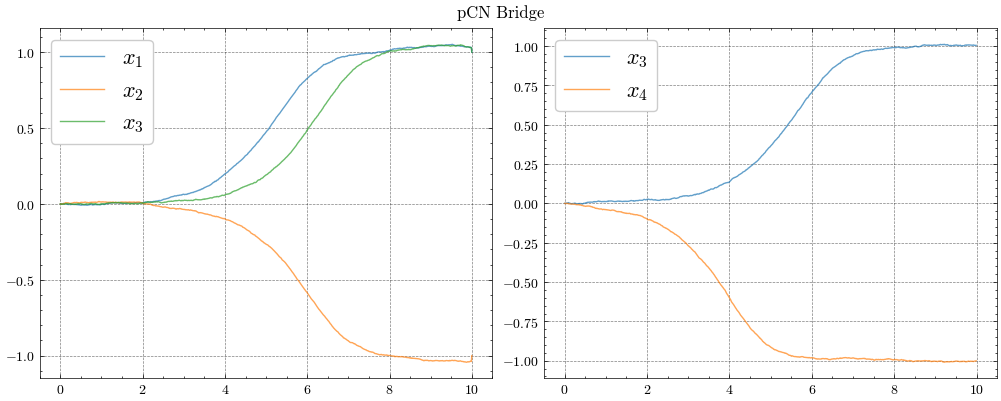

In [23]:
fig, ax = plt.subplots(1, 2, figsize=(10, 4), layout="constrained")
plot_sample_path(pCN_result.path[:16], plot_dims=(0, 1, 2), ax=ax[0], label=["$x_1$", "$x_2$", "$x_3$"])
plot_sample_path(pCN_result.path[:16], plot_dims=(3, 4), ax=ax[1], label=["$x_3$", "$x_4$"])
fig.suptitle("pCN Bridge")

In [24]:
endpoints = pCN_result.path.xs[:, -2, :]
print(endpoints.shape)

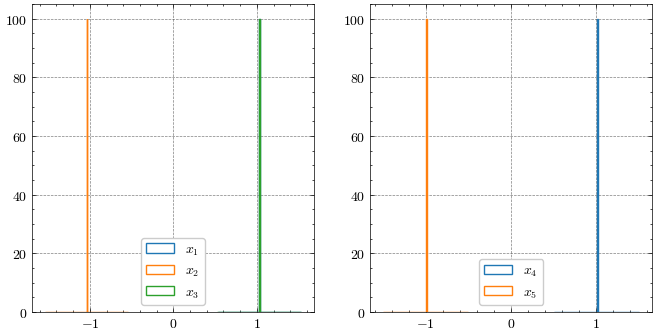

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(8, 4))
ax[0].hist(endpoints[:, 0], bins=100, density=True, histtype="step", label="$x_1$")
ax[0].hist(endpoints[:, 1], bins=100, density=True, histtype="step", label="$x_2$")
ax[0].hist(endpoints[:, 2], bins=100, density=True, histtype="step", label="$x_3$")
ax[0].legend()
ax[1].hist(endpoints[:, 3], bins=100, density=True, histtype="step", label="$x_4$")
ax[1].hist(endpoints[:, 4], bins=100, density=True, histtype="step", label="$x_5$")
ax[1].legend()

In [44]:
neural_net = MLPSmall(
    out_dim=dim,
    hidden_dims=(64, 64, 64, 64),
    activation="tanh",
)

In [45]:
train_config = {
    "save_name": "double_well_model_10T_smaller_sigma",
    "seed": seed,
    "learning_rate": 5e-4,
    "batch_size": 32,
    "n_iters": 1000,
    "n_epochs": 10,
    "ema_decay": 0.995,
    "optimizer": "adam",
    "clip_norm": None,
    "warmup_steps": 1000
}

In [46]:
neural_bridge = neurb.NeuralBridge(X_gui, neural_net, train_config)

In [47]:
W = WienerProcess(T, dt, shape=(dim, ))
neural_bridge.initialize_solver(W)
losses = neural_bridge.train(mode="train")

Training epochs:   0%|          | 0/10 [00:00<?, ?epoch/s]

Epoch 1:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 2:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 3:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 4:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 5:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 6:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 7:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 8:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 9:   0%|          | 0/1000 [00:00<?, ?iter/s]

Epoch 10:   0%|          | 0/1000 [00:00<?, ?iter/s]

In [48]:
X_diamond_path = neural_bridge.solve(x0=u, rng_key=jax.random.PRNGKey(seed), batch_size=500)

Text(0.5, 0.98, 'Conditional Double Well Bridge')

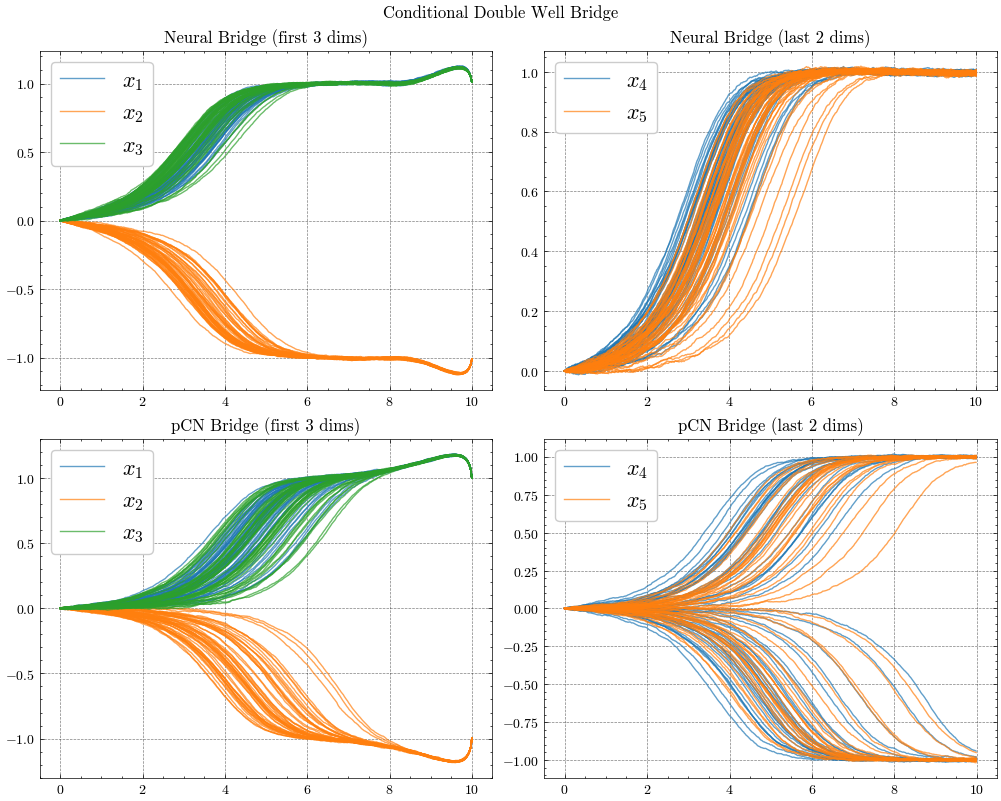

In [51]:
fig, ax = plt.subplots(2, 2, figsize=(10, 8), layout="constrained")
ax = ax.flatten()
plot_sample_path(X_diamond_path[:53], ax=ax[0], plot_dims=(0, 1, 2), label=["$x_1$", "$x_2$", "$x_3$"], title="Neural Bridge (first 3 dims)")
plot_sample_path(X_diamond_path[:53], ax=ax[1], plot_dims=(3, 4), label=["$x_4$", "$x_5$"], title="Neural Bridge (last 2 dims)")
plot_sample_path(pCN_result.path[:53], ax=ax[2], plot_dims=(0, 1, 2), label=["$x_1$", "$x_2$", "$x_3$"], title="pCN Bridge (first 3 dims)")
plot_sample_path(pCN_result.path[:53], ax=ax[3], plot_dims=(3, 4), label=["$x_4$", "$x_5$"], title="pCN Bridge (last 2 dims)")
fig.suptitle("Conditional Double Well Bridge")

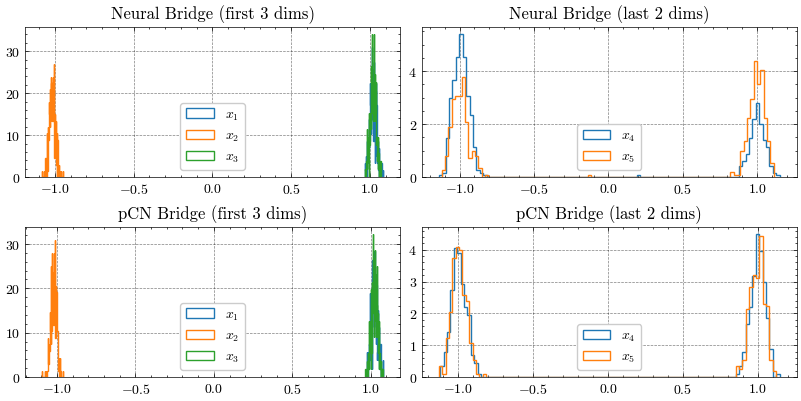

In [24]:
endpoints_neural_bridge = X_diamond_path.xs[:, -2, :]
endpoints_pCN = pCN_result.path.xs[:, -2, :]
fig, ax = plt.subplots(2, 2, figsize=(8, 4), layout="constrained")
ax = ax.flatten()
ax[0].hist(endpoints_neural_bridge[:, 0], bins=100, density=True, histtype="step", label="$x_1$")
ax[0].hist(endpoints_neural_bridge[:, 1], bins=100, density=True, histtype="step", label="$x_2$")
ax[0].hist(endpoints_neural_bridge[:, 2], bins=100, density=True, histtype="step", label="$x_3$")
ax[0].set_title("Neural Bridge (first 3 dims)")
ax[0].legend()
ax[1].hist(endpoints_neural_bridge[:, 3], bins=100, density=True, histtype="step", label="$x_4$")
ax[1].hist(endpoints_neural_bridge[:, 4], bins=100, density=True, histtype="step", label="$x_5$")
ax[1].set_title("Neural Bridge (last 2 dims)")
ax[1].legend()
ax[2].hist(endpoints_pCN[:, 0], bins=100, density=True, histtype="step", label="$x_1$")
ax[2].hist(endpoints_pCN[:, 1], bins=100, density=True, histtype="step", label="$x_2$")
ax[2].hist(endpoints_pCN[:, 2], bins=100, density=True, histtype="step", label="$x_3$")
ax[2].set_title("pCN Bridge (first 3 dims)")
ax[2].legend()
ax[3].hist(endpoints_pCN[:, 3], bins=100, density=True, histtype="step", label="$x_4$")
ax[3].hist(endpoints_pCN[:, 4], bins=100, density=True, histtype="step", label="$x_5$")
ax[3].set_title("pCN Bridge (last 2 dims)")
ax[3].legend()

In [98]:
print("Neural Bridge fraction in (-1.1, 1.1) for x4 and x5:")
print(f"x4: {jnp.logical_and(endpoints_neural_bridge[:, 3] >= -1.1, endpoints_neural_bridge[:, 3] <= 1.1).mean():.3f}")
print(f"x5: {jnp.logical_and(endpoints_neural_bridge[:, 4] >= -1.1, endpoints_neural_bridge[:, 4] <= 1.1).mean():.3f}")

print("\npCN Bridge fraction in (-1.1, 1.1) for x4 and x5:")
print(f"x4: {jnp.logical_and(endpoints_pCN[:, 3] >= -1.1, endpoints_pCN[:, 3] <= 1.1).mean():.3f}")
print(f"x5: {jnp.logical_and(endpoints_pCN[:, 4] >= -1.1, endpoints_pCN[:, 4] <= 1.1).mean():.3f}")

In [95]:
# Check what fraction of endpoints lie in (-1.01, -0.99) or (0.99, 1.01) for each dimension
neural_bridge_in_range = jnp.logical_or(
    jnp.logical_and(endpoints_neural_bridge >= -1.01, endpoints_neural_bridge <= -0.99),
    jnp.logical_and(endpoints_neural_bridge >= 0.99, endpoints_neural_bridge <= 1.01)
)
pcn_in_range = jnp.logical_or(
    jnp.logical_and(endpoints_pCN >= -1.01, endpoints_pCN <= -0.99),
    jnp.logical_and(endpoints_pCN >= 0.99, endpoints_pCN <= 1.01)
)

print("Neural Bridge fraction in (-1.01, -0.99) or (0.99, 1.01) for each dimension:")
for i in range(5):
    print(f"dim {i+1}: {neural_bridge_in_range[:, i].mean():.3f}")

print("\npCN Bridge fraction in (-1.01, -0.99) or (0.99, 1.01) for each dimension:")
for i in range(5):
    print(f"dim {i+1}: {pcn_in_range[:, i].mean():.3f}")
